# 7. Ensemble Learning and Random Forests

- A group of predictors is called an *ensemble*
- Aggregating the predictions of an ensemble is called *ensemble learning*
- An ensemble learning algorithm is called an *ensemble method*

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import time


def computation_time(func):
    def inner(*args, **kwargs):
        start = time.perf_counter()
        func(*args, **kwargs)
        end = time.perf_counter()
        print("Computation time: {:.1f} seconds".format(end - start))

    return inner

## Voting Classifiers

- Given a ensemble of classifiers, a *hard voting* classifier predicts the class that has the most 'votes' among the individual classifiers
- A *soft voting* classifier predicts the class which the highest class probability, averaged over the individual classifiers
- Soft voting gives more weight to confident votes so is more accurate, but requires each individual classifier to estimate class probabilities
- Even if the individual classifiers are *weak learners* (low accuracy), the ensemble can be a *strong learner* (high accuracy)
- Voting classifiers work best if the individual classifiers are indepedent, making uncorrelated errors - this is not the case in practice because the are trained on the same data so are likely to make the same errors
- To approximate independence it is best to use diverse classifiers trained using very different algorithms, so they make diverse errors

In [3]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC

# generate sample data - 2 interleaving half circles
X, y = make_moons(n_samples=200, noise=0.3, random_state=42)

# split into train and test sets, preserving prooprtion of each class
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]

    X_test = X[test_index]
    y_test = y[test_index]

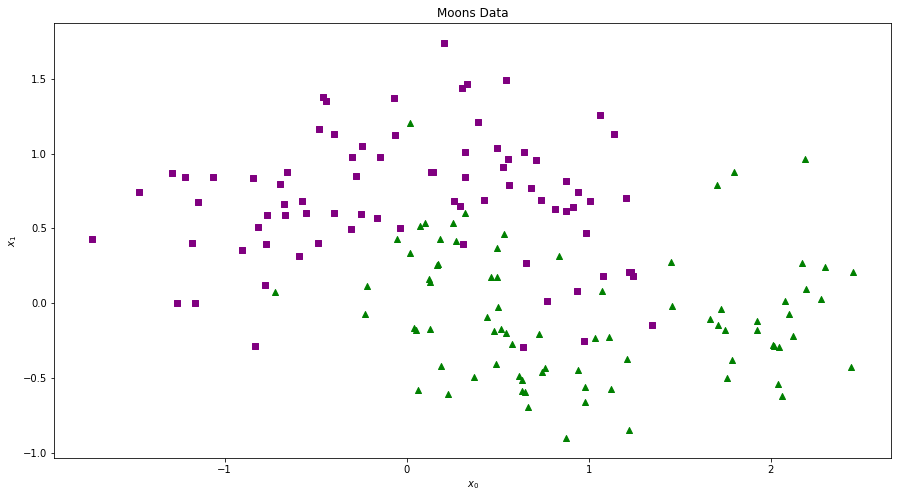

In [4]:
def plot_binary_data(X, y, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.scatter(
        X[:, 0][y == 1],
        X[:, 1][y == 1],
        marker="^",
        color="green",
    )
    ax.scatter(
        X[:, 0][y == 0],
        X[:, 1][y == 0],
        marker="s",
        color="purple",
    )


fig, ax = plt.subplots(figsize=(15, 8))

plot_binary_data(X_train, y_train, ax=ax)

ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")

ax.set_title("Moons Data");

In [5]:
svc_clf = SVC(probability=True, kernel="linear", gamma="scale", random_state=42)
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
for_clf = RandomForestClassifier(n_estimators=100, random_state=42)

estimators = [("log", log_clf), ("svc", svc_clf), ("for", for_clf)]

hard_vote_clf = VotingClassifier(estimators=estimators, voting="hard")
soft_vote_clf = VotingClassifier(estimators=estimators, voting="hard")

hard_vote_clf.fit(X_train, y_train)
soft_vote_clf.fit(X_train, y_train);

In [6]:
# VotingClassifier clones the estimators and stores them in estimators_
for clf in hard_vote_clf.estimators_:
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, ": ", accuracy_score(y_test, y_pred))

y_pred = hard_vote_clf.predict(X_test)
print("HardVoting: ", accuracy_score(y_test, y_pred))

y_pred = soft_vote_clf.predict(X_test)
print("SoftVoting: ", accuracy_score(y_test, y_pred))

LogisticRegression :  0.875
SVC :  0.875
RandomForestClassifier :  0.85
HardVoting:  0.9
SoftVoting:  0.9


In this case hard and soft voting give the same result in this case, but you get the idea.

## Bagging and Pasting

- An alternative to using very different training algorithms is using the same algorithms and training on different random subsets of the training set
- *Bagging* is where each random sample of the dataset is performed with replacement, so each training subset may contain duplicates (bagging is short for *bootstrap aggregating* - in stats sampling with replacement is called *bootstrapping*)
- *Pasting* is where each random sample is performed without replacement
- In both, each sample is taken from the full training set
- The ensemble model typically makes predictions by either taking the most common class (classification) or taking the mean (regression)
- Each individual tree has higher bias than if it were trained on the whole training set (because it 'thinks' all data will look like that subset), but aggregation reduces bias and variance
- Generally the net result is that the ensemble model has similar bias but lower variance than a single predictor trained on the whole training set
- Bagging and pasting scale very well because different predictors can be trained and predictions can be made in parallel; on different CPU cores or different servers

**Bagging and Pasting in Scikit-Learn**
- Bagging and pasting are done with `BaggingClassifier` and `BaggingRegressor`
- `bootstrap = False` sets pasting instead of bagging
- A bagged estimator will have similar bias to a single tree (estimators below have similar training accuracy), but less variance (decision boundaries are more regular)
- Bagging generally has higher bias and lower variance compared with pasting: the model is more likely to learn from the same instances so is more likely to underfit, but the predictors are less correlated because there is more variety in the training sets
- Overall bagging often results in better models

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# generate sample data
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

# tree and random forest
tree_clf = DecisionTreeClassifier(min_weight_fraction_leaf=0.05, random_state=42)
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(min_weight_fraction_leaf=0.05),  # to reduce overfitting
    n_estimators=500,  # number of predictors in the ensemble
    max_samples=100,  # size of each sample
    bootstrap=True,  # bagging, not pasting
    n_jobs=-1,  # max num cores to use at once, -1 means all (8 for me)
    random_state=42,
    oob_score=True,  # see next section
)

tree_clf.fit(X, y)
bag_clf.fit(X, y)

y_pred = tree_clf.predict(X)
acc = accuracy_score(y, y_pred)
print("Decision tree, training accuracy: {:.2f}".format(acc))

y_pred = bag_clf.predict(X)
acc = accuracy_score(y, y_pred)
print("With bagging, training accuracy: {:.2f}".format(acc))

Decision tree, training accuracy: 0.92
With bagging, training accuracy: 0.93


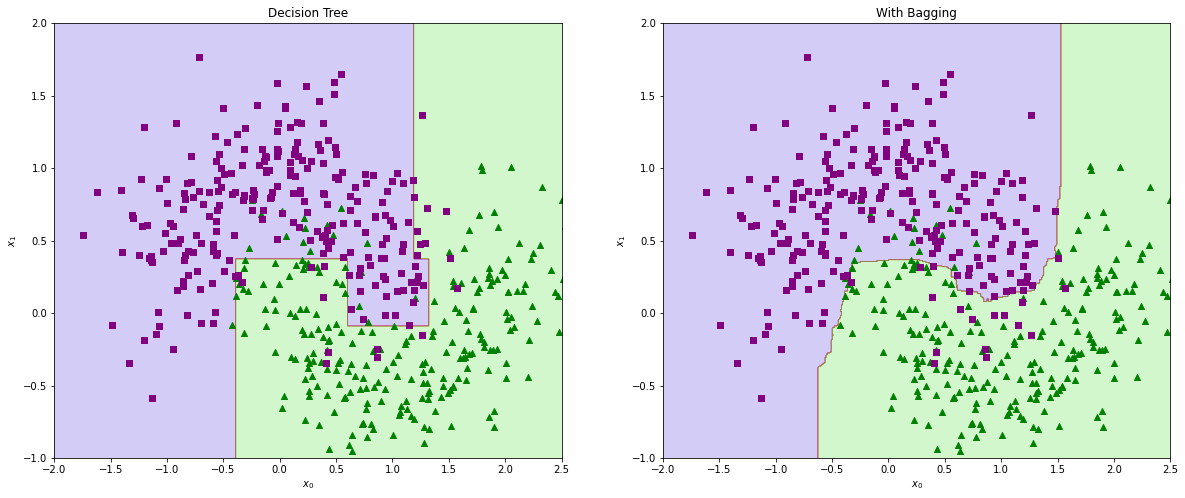

In [8]:
def plot_class_predictions(clf, xlim, ylim, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(15, 8))

    # generate values along each axis
    x0s = np.linspace(xlim[0], xlim[1], 500)
    x1s = np.linspace(ylim[0], ylim[1], 500)

    # all combinations of (x0, x1) for plot
    x0, x1 = np.meshgrid(x0s, x1s)

    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)

    ax.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)


def plot_classifier(clf, xlim, ylim, ax=None, title=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(15, 8))

    plot_class_predictions(clf, xlim, ylim, ax=ax)
    plot_binary_data(X, y, ax=ax)

    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_title(title)


xlim = np.array([-2, 2.5])
ylim = np.array([-1, 2])

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

plot_classifier(tree_clf, xlim, ylim, ax=axs[0], title="Decision Tree")
plot_classifier(bag_clf, xlim, ylim, ax=axs[1], title="With Bagging")

**Out-of-Bag Evalation:**
- With bagging some instances may not be sampled at all: when taking a sample of size $m$, on average only 63% of training samples will be taken (for $m$ largek, see appendix)
- The instances not samples are called *out-of-bag (oob)* instances
- Each individual predictor can be evaluated on the oob instances since it never sees them during training
- You can evaluate the ensemble by averaging the oob evaluations for each predictor
    - *This means:* this means for each training instance, take the predictors for which the instance is oob, use these to generate an overall prediction, calculate the error over all these predictions
    - *This doesn't mean:* calculate the error for each predictor on the oob instances, average these errors (this would be much lower)
    - Oob error is generally pessimistic because each training instance is effectively evaluated on an ensemble with ~37% fewer constituent predictors - this should stabilise as the number of individual predictors increases
    - For accuracy, the bootstrap training sample size should be similar to the original set (according to wiki)
- Oob error is an estimate of generalisation error. It should converge to CV error (specifically leave-on-out CV error), but oob allows you to test the model as it's being trained
    - Sci-kit Learn: "OOB estimates are usually very pessimistic thus we recommend to use cross-validation instead and only use OOB if cross-validation is too time consuming"
- You can also get the overall decision function - averaging the decision functions for oob instances for each predictor
- To get these you must set `oob_score = True` on the estimator

In [9]:
# oob score directly - sklearn uses accuracy as the oob metric
oob_acc = bag_clf.oob_score_
print("Mean Out-of-Bag Accuracy: {:.3f}".format(oob_acc))

# calculated from the decision function
y_pred = np.argmax(bag_clf.oob_decision_function_, axis=1)
print("Mean Out-of-Bag Accuracy: {:.3f}".format(accuracy_score(y, y_pred)))

# compare with generalisation error by generating another sample using same params
X_test, y_test = make_moons(n_samples=100, noise=0.3, random_state=43)
y_pred = bag_clf.predict(X_test)
print("Test Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))

Mean Out-of-Bag Accuracy: 0.908
Mean Out-of-Bag Accuracy: 0.908
Test Accuracy: 0.900


**Random Patches and Random Subspaces:**
- `BaggingClassifier` also allows you to randomly sample features using `max_features` and `bootstrap_features`, so each predictor is trained on a random subset of input features
- Sampling both training instances and features is called *random patches*
- Sampling just features is called the *random subspaces* method
- Sampling feautres results in more predictor diversity so increases bias but decreases variance
- It is most useful when you have high-dimensional inputs such as images

## Random Forests

- A random forest is an ensemble of decision trees, generally trained using bagging and with `max_samples` equal to the size of the training set
- `RandomForestClassifier` and `RandomForestRegression` apply bagging to `DecisionTreeClassifier` and `DecisionTreeRegressor` and are better optimised
- You can pass almost all bagging and decision tree parameters to random forests, but a few have fixed values: `splitter = random`, `presort=False`, `max_samples=1.0`
- Random splitter means that at each node it searches for the best feature among a random subset of features. This results in greater tree diversity which means higher bias, but lower variance - usually an improvement

Training Accuracy: 0.94
Mean Out-of-Bag Accuracy: 0.92


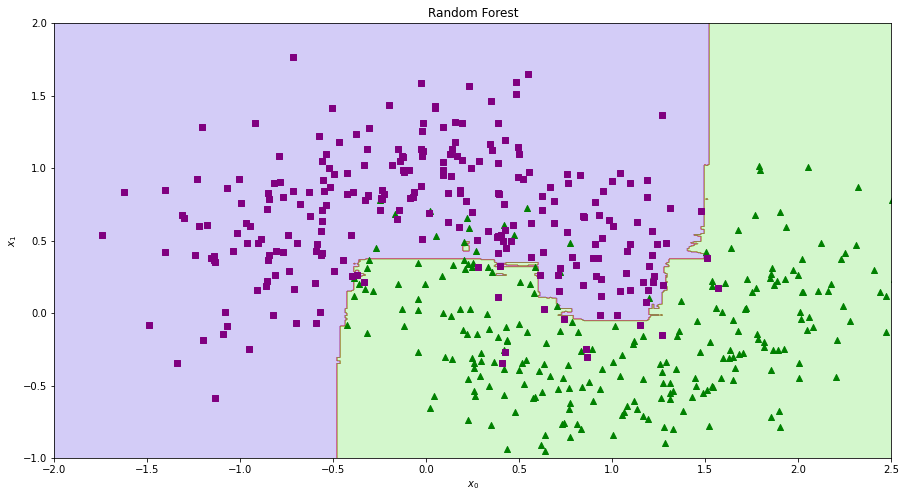

In [10]:
from sklearn.ensemble import RandomForestClassifier

fst_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    oob_score=True,
)
fst_clf.fit(X, y)

y_pred = fst_clf.predict(X)
acc = accuracy_score(y, y_pred)
print("Training Accuracy: {:.2f}".format(acc))

oob_acc = fst_clf.oob_score_
print("Mean Out-of-Bag Accuracy: {:.2f}".format(oob_acc))

xlim = np.array([-2, 2.5])
ylim = np.array([-1, 2])

plot_classifier(fst_clf, xlim, ylim, title="Random Forest")

**Extra-Trees:**
- You can make trees even more random by using random thresholds for each feature rather than searching for the best possible thresholds
- A forest of such  extremely random trees is called an *extremely randomised trees ensemble* (or *extra-trees*)
- This trades more bias for a lower variance
- This is much faster to train because finding the best threshold is the most time-consuming part of training a tree
- You can only really tell if a random forest or extra-trees ensemble will be better by training both and comparing

Training Accuracy: 0.93
Mean Out-of-Bag Accuracy: 0.90


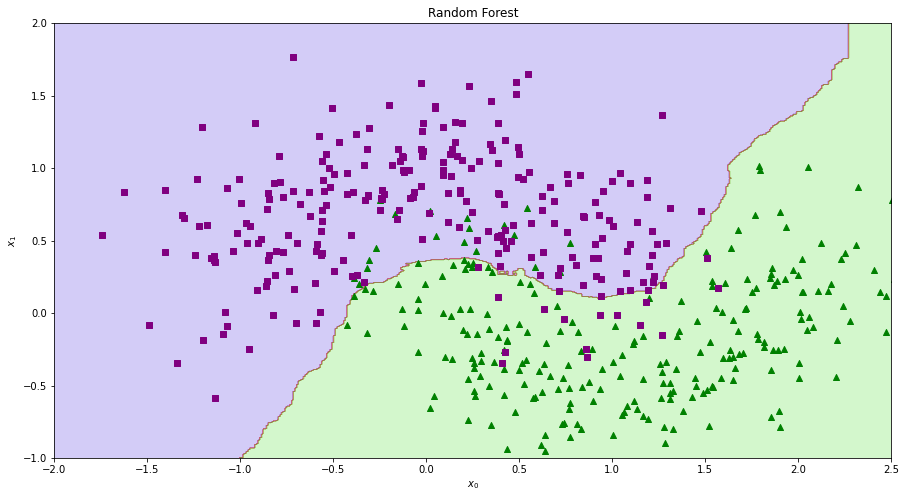

In [11]:
from sklearn.ensemble import ExtraTreesClassifier

xtr_clf = ExtraTreesClassifier(
    n_estimators=1000,
    max_leaf_nodes=16,
    bootstrap=True, # note false by default - uses whole dataset
    n_jobs=-1,
    oob_score=True,
)
xtr_clf.fit(X, y)

y_pred = xtr_clf.predict(X)
acc = accuracy_score(y, y_pred)
print("Training Accuracy: {:.2f}".format(acc))

oob_acc = xtr_clf.oob_score_
print("Mean Out-of-Bag Accuracy: {:.2f}".format(oob_acc))

xlim = np.array([-2, 2.5])
ylim = np.array([-1, 2])

plot_classifier(xtr_clf, xlim, ylim, title="Random Forest")

**Feature Importance:** 
- Scikit-Learn estimates the importance of each feature in a tree or random forest
    - For each node, it looks at the average reduction in gini impurity to the child nodes:

\begin{equation}
    G_{\text{parent}} - \left( \frac{m_{\text{left}}}{m_{\text{parent}}} G_{\text{left}} + \frac{m_{\text{right}}}{m_{\text{parent}}} G_{\text{right}} \right)
\end{equation}

    - For each feature, it takes the average of this for all nodes using that feature (weighted by number of samples)
    - Finally it normalises so that feature importances sum to 1

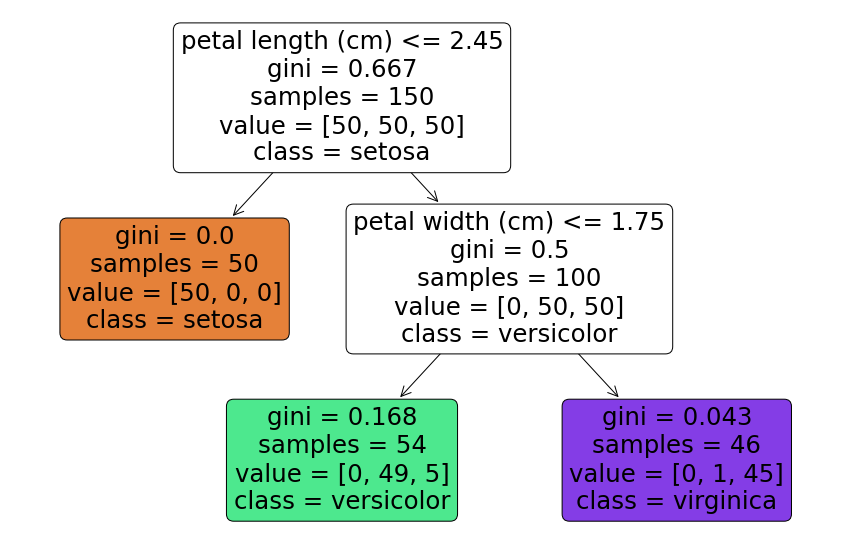

In [12]:
# example with a simple decision tree
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import shuffle

# import iris sample data
iris = load_iris()

X = pd.DataFrame(data=iris["data"], columns=iris["feature_names"])
y = iris["target"]

# shuffle since data is ordered by class
X, y = shuffle(X, y)

# restrict to 2 features
X_petal = X[["petal length (cm)", "petal width (cm)"]]

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_petal, y);

fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(
    tree_clf,
    feature_names=X_petal.columns,
    class_names=iris["target_names"],
    rounded=True,
    filled=True,
);

In [13]:
# manual calculation of feature importances

# since we normalise at the end anyway, we can just average weighted impurity m*G
# instead of doing weighted averages of impurity
def weighted_gini_impurity(list):
    list_sum = sum(list)
    
    gini = 1
    for p in list:
        gini -= (p / list_sum)**2
    
    return list_sum * gini


feat_imp = {
}

feat_imp["Petal Length"] = weighted_gini_impurity([50, 50, 50]) 
feat_imp["Petal Length"] -= weighted_gini_impurity([50, 0, 0])  + weighted_gini_impurity([0, 50, 50])

feat_imp["Petal Width"] = weighted_gini_impurity([0, 50, 50])
feat_imp["Petal Width"] -= weighted_gini_impurity([0, 49, 5]) + weighted_gini_impurity([0, 1, 45])

def normalize_dict(dict):
    "Rescale values so they sum to 1"
    val_sum = sum(dict.values())

    for key in dict.keys():
        dict[key] /= val_sum
    
    return dict


feat_imp = normalize_dict(feat_imp)

for key, val in feat_imp.items():
    print("\'{}\' importance: {:.2f}".format(key, val))

'Petal Length' importance: 0.56
'Petal Width' importance: 0.44


In [14]:
# from estimator
for name, importance in zip(X_petal.columns, tree_clf.feature_importances_):
    print("\'{}\' importance: {:.2f}".format(name, importance))

'petal length (cm)' importance: 0.56
'petal width (cm)' importance: 0.44


In [15]:
# random forest on all features
fst_clf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
fst_clf.fit(X, y)

for name, importance in zip(X.columns, fst_clf.feature_importances_):
    print("\'{}\' importance: {:.2f}".format(name, importance))

'sepal length (cm)' importance: 0.11
'sepal width (cm)' importance: 0.02
'petal length (cm)' importance: 0.44
'petal width (cm)' importance: 0.42


In [16]:
# plotting importances for mnist data
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)

# load data into dataframes
X, y = mnist["data"], mnist["target"]

# use predefined train/test split
X_train, X_test, y_train, y_test = (
    X.iloc[:60000],
    X.iloc[60000:],
    y.iloc[:60000],
    y.iloc[60000:],
)

# train random forest
frst_clf = RandomForestClassifier(n_estimators=100, random_state=42)
frst_clf.fit(X_train, y_train);

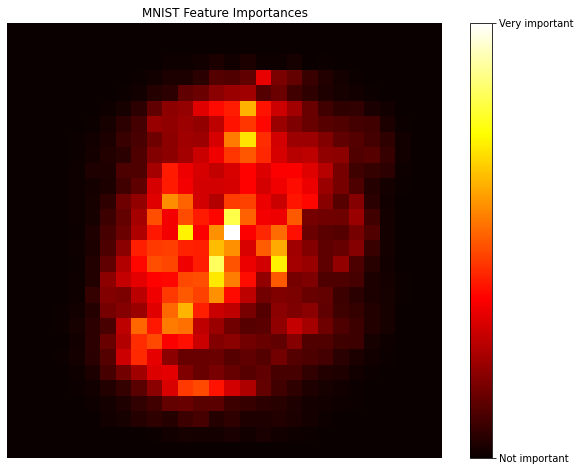

In [17]:
def plot_feature_importances(clf):
    feat_imp = frst_clf.feature_importances_
    feat_imp_image = feat_imp.reshape(28, 28)
    
    fig, ax = plt.subplots(figsize=(10, 8))

    im = ax.imshow(feat_imp_image, cmap=plt.cm.hot)

    cbar = fig.colorbar(im, ticks=[feat_imp.min(), feat_imp.max()])
    cbar.ax.set_yticklabels(['Not important', 'Very important'])

    ax.set_title("MNIST Feature Importances")

    ax.axis("off");


plot_feature_importances(frst_clf)

## Boosting

- *Boosting* or (*hypothesis boosting*) is any ensemble method that combines several weak learners into a strong learner
- Generally you train predictors sequentially, each one trying to correct its predecessors

**AdaBoost**
- *AdaBoost* (short for *adaptive boosting*) seeks to sequentially improve the ensemble by adding new predictors that pay more attention to the training instances the predecessor underfitted
- The textbook deals with the multiclass case, I'm going to restrict to binary. Code the targets as $y^{(i)}\in\{\pm 1 \}$ *(I don't quite understand the multiclass extension)*
- Our goal is to end up with a decision function $h(\mathbf{x}) = \sum_{j=1}^N \alpha_j \hat{y}_j(\mathbf{x})$, where $\alpha_j\in\mathbb{R}$ and the $\hat{y}_j$ are from models trained on the same training set with weights $w_j^{(i)}$, $\sum_{i=1}^m w_j^{(i)}=1$. We then predict $\hat{y}(\mathbf{x})=\text{sgn}(h(\mathbf{x}))$
- We start with all $w_1^{(i)}=1/m$ and then define the $\alpha_j$ and $w_j^{(i)}$ recursively to minimise the sum of exponential loss at training instances $\sum_{i=1}^m \exp\left(-y^{(i)}h(\mathbf{x}^{(i)})\right)$
- At step $j$, train a model on the training data with weights $w^{(i)}_j$ and let $r_j = \sum_{\hat{y}_j^{(i)}\neq y^{(i)}} w_j^{(i)}$ be the weighted error rate (remember the $w_j^{(i)}$ are normalised). Then define $\alpha_j = \ln\left((1-r_j)~\big/~r_j\right)$ and add $\alpha_j y_j$ to $h$. Finally we set training weights for the next iteration (and then normalise them):

\begin{equation}
    w_{j+1}^{(i)} = \begin{cases}
        w^{(i)} & \text{if } \hat{y}_j^{(i)} = y^{(i)} \\
        \exp(\alpha_j) w^{(i)} & \text{if } \hat{y}_j^{(i)} \neq y^{(i)} \\
    \end{cases}
\end{equation}

- If $r_j<0.5$ then the new classifier is better than random guessing, $\alpha_j > 0$, and $\exp(\alpha_j) > 1$, so we add a positive multiple of the classifer to our model and increase the weights of misclassified training instances
- If $r_j>0.5$ then we effectively swap our classifer with its negative (which is then better than random guessing), so we add a *negative* multiple of the classifer to our model, and reduce the weights of misclassifed training instances (as these were correctly classified by the negative of the classifier)
- We can add a *learning rate* hyperparameter $\eta$ by replacing $\alpha_j$ with $\eta \alpha_j$. This introduces the contribution of each classifier - if you decrease $\eta$ you probably need more total estimators
- Scikit-Learn uses a multiclass generalisation of this called *Stagewise Additive Modelling using a Multiclass Exponential loss function (SAMME)*
- This implementation (using just the class predictions) is called *discrete AdaBoost*. If the boosted predictors support class probabilites then Scikit-Learn can use SAMME.R, or *real AdaBoost*. This generally performs better
- AdaBoost is often applied to *decision stumps* - decision trees with depth 1

In [81]:
from sklearn.ensemble import AdaBoostClassifier

# generate sample data
X_train, y_train = make_moons(n_samples=1000, noise=0.3, random_state=42)
X_test, y_test = make_moons(n_samples=200, noise=0.3, random_state=43)

# stump
stump_clf = DecisionTreeClassifier(max_depth=1)
stump_clf.fit(X_train, y_train)

y_pred = stump_clf.predict(X_test)
stump_err = 1 - accuracy_score(y_test, y_pred)

# decision tree
tree_clf = DecisionTreeClassifier(min_weight_fraction_leaf=0.05, random_state=42)
tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test)
tree_err = 1 - accuracy_score(y_test, y_pred)

In [105]:
n_estimators = 1000
learning_rate = 0.5

# train real adaboost
ada_real_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), # decision stumps
    n_estimators=n_estimators,
    algorithm="SAMME.R", # real adaboost
    learning_rate=learning_rate
)
ada_real_clf.fit(X_train, y_train)

# train discrete adaboost
ada_disc_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), # decision stumps
    n_estimators=n_estimators,
    algorithm="SAMME", # discrete adaboost
    learning_rate=learning_rate
)
ada_disc_clf.fit(X_train, y_train);

In [106]:
# get training and test error against number of estimators
ada_real_err = np.zeros(n_estimators)

for i, y_pred in enumerate(ada_real_clf.staged_predict(X_test)):
    ada_real_err[i] = 1 - accuracy_score(y_test, y_pred)

ada_real_train_err = np.zeros(n_estimators)

for i, y_pred in enumerate(ada_real_clf.staged_predict(X_train)):
    ada_real_train_err[i] = 1 - accuracy_score(y_train, y_pred)

ada_disc_err = np.zeros(n_estimators)

for i, y_pred in enumerate(ada_disc_clf.staged_predict(X_test)):
    ada_disc_err[i] = 1 - accuracy_score(y_test, y_pred)

ada_disc_train_err = np.zeros(n_estimators)

for i, y_pred in enumerate(ada_disc_clf.staged_predict(X_train)):
    ada_disc_train_err[i] = 1 - accuracy_score(y_train, y_pred)

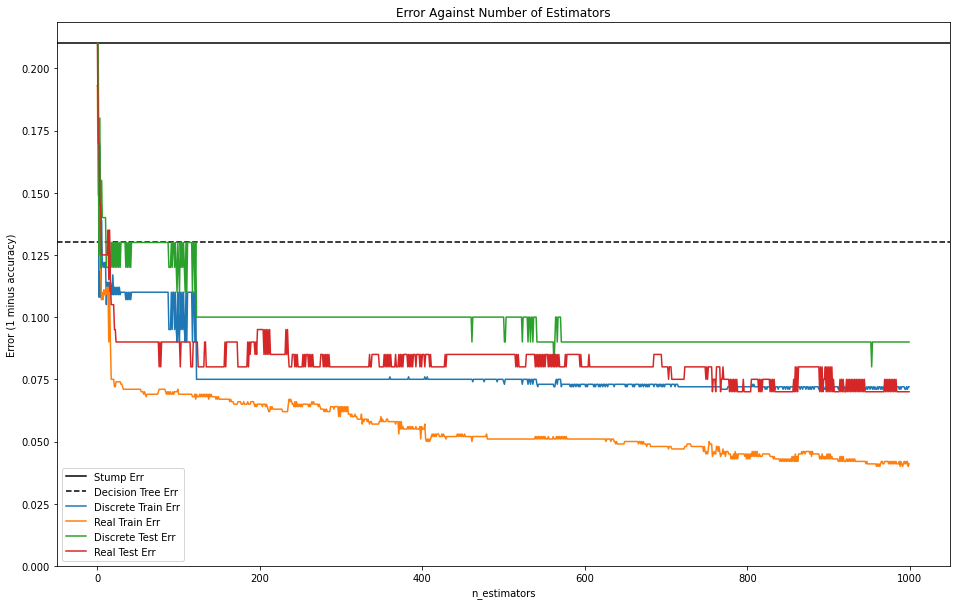

In [109]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.axhline(stump_err, color="k", label = "Stump Err")
ax.axhline(tree_err, color="k", ls= "--", label = "Decision Tree Err")

x_plot = np.arange(n_estimators)

ax.plot(x_plot, ada_disc_train_err, label = "Discrete Train Err")
ax.plot(x_plot, ada_real_train_err, label = "Real Train Err")

ax.plot(x_plot, ada_disc_err, label = "Discrete Test Err")
ax.plot(x_plot, ada_real_err, label = "Real Test Err")

ax.set_ylim(bottom=0)

ax.set_xlabel("n_estimators")
ax.set_ylabel("Error (1 minus accuracy)")

ax.set_title("Error Against Number of Estimators")

ax.legend();

# Appendix

## Out-of-Bag Evaluation

We prove the claim that if a bagging classifier samples $m$ training instances with replacement then "only about 63% of the training instances are sampled on average for each predictor".

Suppose we have a set $X$ of size $m$ and we sample it $n$ times with replacement. Let $D$ be the random variable that gives the number of distinct elements of $m$ that are sampled. We claim that

\begin{equation}
    \mathbb{E}(D_n) = \frac{m^n-(m-1)^n}{m^{n-1}} = m \left( 1 - \left( 1 - \frac{1}{m}\right)^n\right).
\end{equation}

Note that if this is true then the result follows since the proportion of training instances sampled is $\mathbb{E}(D_n) \big/ m = 1 - \left( 1 - \frac{1}{m}\right)^n$ which tends to $1-e^{-1}\approx 0.63$ as $m\to\infty$ if $m=n$.

To prove the claim we use (strong) induction on $n$. The claim is clearly true for $n=1$ so take $n>1$. The important observation is that to get $D_n=k$, you need to either have $D_{n-1}=k$ and then pick the next sample from one of those already sampled (probability $k/m$), or have $D_{n-1}=k-1$ and then pick the next sample from one of those not already sampled (probability $(m-k+1)/m$). From this we have

\begin{align}
    \mathbb{E}(D_n)
        & = \sum_{k=1}^n k P(D_n=k) \\
        & = \sum_{k=1}^n k\left( \frac{k}{m} P(D_{n-1}=k) + \frac{m-k+1}{m} P(D_{n-1}=k-1)\right) \\
        & = \frac{1}{m} \left[ \sum_{k=1}^{n-1} k^2 P(D_{n-1}=k) + \sum_{j=1}^{k-1} (j+1)(m-j) P(D_{n-1}=j)\right] \\
        & = \frac{1}{m} \sum_{k=1}^{n-1} \left[(m-1)k + m\right] P(D_{n-1}=k)\ \\
        & = \frac{1}{m}\left[ (m-1)\frac{m^{n-1} - (m-1)^{n-1}}{m^{n-1}} + m\right] \\
        & = \frac{1}{m^n}\left[ (m-1)\left(m^{n-1} - (m-1)^{n-1}\right) + m^{n-1}\right] \\
        & = \frac{m^n - (m-1)^{n-1}}{m^n} \\
\end{align}

as required.

In [ ]:
# generate sample data
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_test, y_test = make_moons(n_samples=100, noise=0.3, random_state=43)